# Modelling

In this script, we try to find the optimal model to predict the outcome of NBA games, given the training set that we've wrangled and engineered in previous scripts.  We start by finding the accuracy we would get with a simple dummy model, and then optimize the more simple algorithms (logistic regression, decision tree, etc.) with a grid search.  Finally, we will look into whether we can achieve higher accuracy with neural networks.

We begin by importing the dataset generated in `Data_Wrangling.ipynb`.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Data/games_modelling2.csv')

As usual, let's also create our dictionary that converts between team name and team id.  We may not need it, but it could come in useful.

In [3]:
# load in the teams dataset
teams = pd.read_csv('Data/teams.csv')

# generate a team name-ID dictionary from the teams dataset
teams = teams[['TEAM_ID', 'ABBREVIATION']]
teams = teams.set_index('TEAM_ID')
id_to_name = teams.to_dict()['ABBREVIATION']

# generate this same dictionary in reverse (i.e. ID-name instead of name-ID)
name_to_id = dict((v,k) for k,v in id_to_name.items())  

In [4]:
df.head()

,home_avg_pts_for,away_avg_pts_for,home_avg_pts_against,away_avg_pts_against,home_avg_reb_for,away_avg_reb_for,home_avg_reb_against,away_avg_reb_against,home_avg_ast_for,away_avg_ast_for,home_avg_ast_against,away_avg_ast_against,home_win_pct,away_win_pct,is_home_win
0,103.4,91.2,94.9,84.5,43.1,46.8,42.7,45.0,24.7,21.5,24.7,20.6,0.800,0.600,1
1,93.8,91.2,93.2,89.9,42.2,44.2,42.6,45.2,20.1,21.2,20.9,22.3,0.500,0.462,0
2,88.3,90.2,80.7,90.2,42.2,39.1,41.6,40.6,20.6,20.1,20.5,21.8,0.867,0.500,1
3,90.6,86.2,96.2,93.6,43.6,42.4,45.2,40.9,19.4,16.8,20.8,19.9,0.312,0.267,1
4,93.7,89.3,89.2,93.7,43.6,47.3,43.0,45.5,19.4,22.3,20.4,22.3,0.625,0.267,1


Alright, let's start the modelling!  We begin by importing the `scikit-learn` libraries we will need, and separating into features and target and train-test splitting.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')

In [7]:
X = df.drop('is_home_win', axis=1)
y = df['is_home_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next, let's check what happens if we just predict the mode, or the team with the better win percentage.  These will act as dummy models to which we can compare the performance of our real ML models.

In [8]:
df['is_home_win'].value_counts()[1] / df.shape[0]

0.5948762483716891

In [9]:
df['is_home_team_better'] = np.where(df['home_win_pct'] > df['away_win_pct'], 1, 0)
df['dummy_prediction'] = np.where(df['is_home_win'] == df['is_home_team_better'], 1, 0)

df['dummy_prediction'].value_counts()[1] / df.shape[0]

0.6473543824824762

It looks like our best dummy model is one that would predict the team with the higher winning percentage wins, and would predict game outcomes with a 64.7% accuracy.

Let's see if we can beat it.  We'll start with a simple, unoptimized logistic regression classifier:

In [10]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

0.6705955334987593
0.6626356589147286


It looks like with an unoptimized logistic regression model, we can get slightly better than just predicting the better team will win.  Let's see if we can do better by optimizing with a grid search.  We can run the following cell, or load in the fitted grid from memory, since this cell has already been run and the results saved with joblib.

In [12]:
# step 1: set up the pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearSVC())]

pipe = Pipeline(estimators)

# step 2: set up the gridsearch
param_grid = [
             {'model': [LinearSVC()],
             'normalise': [StandardScaler(), MinMaxScaler()],
             'model__penalty': ['l1', 'l2'],
             'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
            {'model': [DecisionTreeClassifier()],
             'model__max_depth': np.arange(1, 10)},
    
            {'model': [LogisticRegression(penalty='l2')], 
             'normalise': [StandardScaler(), MinMaxScaler()],
             'model__solver': ['lbfgs', 'newton-cg', 'sag', 'liblinear', 'saga'],
             'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
            {'model': [LogisticRegression(penalty='l1')],
             'normalise': [StandardScaler(), MinMaxScaler()], 
             'model__solver': ['liblinear', 'saga'],
             'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}    

]

# step 3: instantiate and fit the GridSearch object
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
fittedgrid = grid.fit(X_train, y_train)

joblib.dump(fittedgrid, 'Data/grid_search.pkl')

Fitting 5 folds for each of 167 candidates, totalling 835 fits
[CV] END model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=0.0001, model__pen

[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=1, model__penalty=l

[CV] END model=LinearSVC(), model__C=1000, model__penalty=l2, normalise=MinMaxScaler(); total time=   0.5s
[CV] END model=LinearSVC(), model__C=1000, model__penalty=l2, normalise=MinMaxScaler(); total time=   0.5s
[CV] END model=LinearSVC(), model__C=10000, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=10000, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=10000, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=10000, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=10000, model__penalty=l1, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=10000, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LinearSVC(), model__C=10000, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=Linea

[CV] END model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.00

[CV] END model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.

[CV] END model=LogisticRegression(), model__C=0.1, model__solver=newton-cg, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__solver=newton-cg, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__solver=newton-cg, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__solver=newton-cg, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__solver=newton-cg, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__solver=newton-cg, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), m

[CV] END model=LogisticRegression(), model__C=1, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1, model__solver=liblinear, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1, model__solver=liblinear, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1, model__solver=liblinear, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1, model__solver=liblinear, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1, model__solver=liblinear, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1, model__solver=saga, normalise=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__solver=saga, normalise=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, mod

[CV] END model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__solver=newton-cg, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__solver=newton-cg, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__solver=newton-cg, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__solver=newton-cg, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), mod

[CV] END model=LogisticRegression(), model__C=1000, model__solver=sag, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__solver=sag, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__solver=sag, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__solver=sag, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), mod

[CV] END model=LogisticRegression(), model__C=10000, model__solver=saga, normalise=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10000, model__solver=saga, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10000, model__solver=saga, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10000, model__solver=saga, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10000, model__solver=saga, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10000, model__solver=saga, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model

[CV] END model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=saga, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=saga, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=saga, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.1, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.1, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.1, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.1, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=0.1, model__sol

[CV] END model=LogisticRegression(penalty='l1'), model__C=100, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=100, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=100, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(penalty='l1'), model__C=100, model__solver=liblinear, normalise=MinMaxScaler(); total time=   5.8s
[CV] END model=LogisticRegression(penalty='l1'), model__C=100, model__solver=liblinear, normalise=MinMaxScaler(); total time=   3.7s
[CV] END model=LogisticRegression(penalty='l1'), model__C=100, model__solver=liblinear, normalise=MinMaxScaler(); total time=   5.4s
[CV] END model=LogisticRegression(penalty='l1'), model__C=100, model__solver=liblinear, normalise=MinMaxScaler(); total time=   6.1s
[CV] END model=LogisticRegression(penalty='l1'), model__C=100, 

['Data/grid_search.pkl']

In [13]:
fittedgrid = joblib.load('Data/grid_search.pkl')

In [14]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=0.001, solver='liblinear'))])

It looks like the best model out of all our combinations here is still a logistic regression classifier, with some regularization and scaling.  Let's check its accuracy.

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(C=0.001, solver='liblinear', random_state=42)
logreg.fit(X_train_scaled, y_train)

print(logreg.score(X_train_scaled, y_train))
print(logreg.score(X_test_scaled, y_test))

0.6717586848635235
0.6688372093023256


From the test accuracy, it looks like we're still getting slightly better than our dummy model.  It might be interesting to look at the coefficient values.

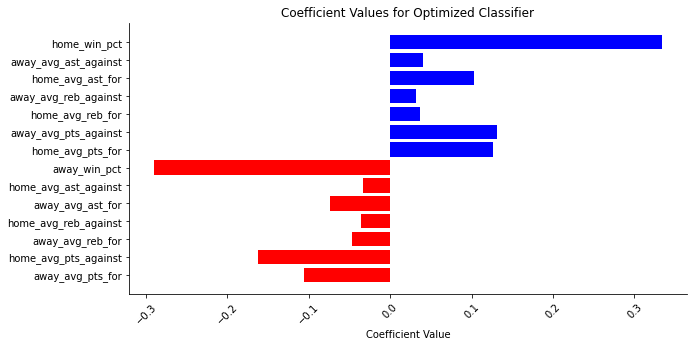

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

mask1 = logreg.coef_[0] < 0
mask2 = logreg.coef_[0] >= 0

plt.figure(figsize=(10, 5))
plt.barh(X_train.columns[mask1], logreg.coef_[0][mask1], color='red')
plt.barh(X_train.columns[mask2], logreg.coef_[0][mask2], color='blue')
plt.xticks(rotation=45)
plt.xlabel('Coefficient Value')
plt.title('Coefficient Values for Optimized Classifier')
sns.despine()
plt.show()

From the coefficients, we get behaviour that makes sense.  The two features which are most predictive are home and away winning percentage, and the other coefficients make sense too.  All of the negative coefficients are positive things for the away team or negative things for the home team, and vice versa with the positive coefficients.  This makes sense because, for example, if the home team gives up more points on average, it's less likely that the home team will win, and this is reflected in the negatively valued coefficient for `home_avg_pts_against`.  

I have a feeling that we can still do better, so let's take a look at neural networks.

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 

model.add(layers.Dense(40, activation="relu")) 
model.add(layers.Dropout(0.2))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Train the network
history = model.fit(X_train_scaled, y_train, epochs=500, verbose=1)

# Evaluate the network
train_accuracy = history.history["binary_accuracy"][-1]
result = model.evaluate(X_test_scaled,y_test, verbose=1)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Epoch 1/500
403/403 [==============================] - 0s 755us/step - loss: 0.6609 - binary_accuracy: 0.6238
Epoch 2/500
403/403 [==============================] - 0s 760us/step - loss: 0.6307 - binary_accuracy: 0.6465
Epoch 3/500
403/403 [==============================] - 0s 753us/step - loss: 0.6248 - binary_accuracy: 0.6476
Epoch 4/500
403/403 [==============================] - 0s 730us/step - loss: 0.6194 - binary_accuracy: 0.6584
Epoch 5/500
403/403 [==============================] - 0s 811us/step - loss: 0.6172 - binary_accuracy: 0.6632 0s - loss: 0.6169 - binary_accuracy: 0
Epoch 6/500
403/403 [==============================] - 0s 715us/step - loss: 0.6135 - binary_accuracy: 0.6620
Epoch 7/500
403/403 [==============================] - 0s 712us/step - loss: 0.6165 - binary_accuracy: 0.6623
Epoch 8/500
403/403 [==============================] - 0s 707us/step - loss: 0.6148 - binary_accuracy: 0.6635
Epoch 9/500
403/403 [==============================] - 0s 717us/step - loss: 0.61

403/403 [==============================] - 0s 1ms/step - loss: 0.5939 - binary_accuracy: 0.6814A: 0s - loss: 0.5953 - binary_accuracy: 0.6
Epoch 145/500
403/403 [==============================] - 0s 1ms/step - loss: 0.5930 - binary_accuracy: 0.6798
Epoch 146/500
403/403 [==============================] - 0s 1ms/step - loss: 0.5929 - binary_accuracy: 0.6839
Epoch 147/500
403/403 [==============================] - 0s 857us/step - loss: 0.5923 - binary_accuracy: 0.6826
Epoch 148/500
403/403 [==============================] - 0s 870us/step - loss: 0.5920 - binary_accuracy: 0.6846
Epoch 149/500
403/403 [==============================] - 0s 836us/step - loss: 0.5914 - binary_accuracy: 0.6862
Epoch 150/500
403/403 [==============================] - 0s 830us/step - loss: 0.5895 - binary_accuracy: 0.6866
Epoch 151/500
403/403 [==============================] - 0s 778us/step - loss: 0.5901 - binary_accuracy: 0.6904
Epoch 152/500
403/403 [==============================] - 0s 742us/step - loss: 0.

Epoch 217/500
403/403 [==============================] - 0s 693us/step - loss: 0.5910 - binary_accuracy: 0.6815
Epoch 218/500
403/403 [==============================] - 0s 685us/step - loss: 0.5869 - binary_accuracy: 0.6826
Epoch 219/500
403/403 [==============================] - 0s 677us/step - loss: 0.5913 - binary_accuracy: 0.6855
Epoch 220/500
403/403 [==============================] - 0s 687us/step - loss: 0.5896 - binary_accuracy: 0.6879
Epoch 221/500
403/403 [==============================] - 0s 688us/step - loss: 0.5866 - binary_accuracy: 0.6853
Epoch 222/500
403/403 [==============================] - 0s 702us/step - loss: 0.5874 - binary_accuracy: 0.6914
Epoch 223/500
403/403 [==============================] - 0s 705us/step - loss: 0.5885 - binary_accuracy: 0.6854
Epoch 224/500
403/403 [==============================] - 0s 683us/step - loss: 0.5878 - binary_accuracy: 0.6832
Epoch 225/500
403/403 [==============================] - 0s 684us/step - loss: 0.5870 - binary_accuracy:

403/403 [==============================] - 0s 750us/step - loss: 0.5874 - binary_accuracy: 0.6911
Epoch 290/500
403/403 [==============================] - 0s 688us/step - loss: 0.5844 - binary_accuracy: 0.6886
Epoch 291/500
403/403 [==============================] - 0s 960us/step - loss: 0.5875 - binary_accuracy: 0.6846
Epoch 292/500
403/403 [==============================] - 0s 852us/step - loss: 0.5866 - binary_accuracy: 0.6909
Epoch 293/500
403/403 [==============================] - 0s 724us/step - loss: 0.5886 - binary_accuracy: 0.6865
Epoch 294/500
403/403 [==============================] - 0s 705us/step - loss: 0.5880 - binary_accuracy: 0.6841
Epoch 295/500
403/403 [==============================] - 0s 702us/step - loss: 0.5839 - binary_accuracy: 0.6878
Epoch 296/500
403/403 [==============================] - 0s 689us/step - loss: 0.5880 - binary_accuracy: 0.6863
Epoch 297/500
403/403 [==============================] - 0s 682us/step - loss: 0.5858 - binary_accuracy: 0.6908
Epoch 

Epoch 434/500
403/403 [==============================] - 0s 698us/step - loss: 0.5839 - binary_accuracy: 0.6887
Epoch 435/500
403/403 [==============================] - 0s 702us/step - loss: 0.5857 - binary_accuracy: 0.6901
Epoch 436/500
403/403 [==============================] - 0s 712us/step - loss: 0.5834 - binary_accuracy: 0.6922
Epoch 437/500
403/403 [==============================] - 0s 723us/step - loss: 0.5840 - binary_accuracy: 0.6887
Epoch 438/500
403/403 [==============================] - 0s 701us/step - loss: 0.5843 - binary_accuracy: 0.6932
Epoch 439/500
403/403 [==============================] - 0s 747us/step - loss: 0.5844 - binary_accuracy: 0.6859
Epoch 440/500
403/403 [==============================] - 0s 698us/step - loss: 0.5841 - binary_accuracy: 0.6899
Epoch 441/500
403/403 [==============================] - 0s 713us/step - loss: 0.5843 - binary_accuracy: 0.6894
Epoch 442/500
403/403 [==============================] - 0s 710us/step - loss: 0.5850 - binary_accuracy:

With a first pass at creating a neural network to make predictions, it looks like we're overfitting the training set slightly.  There might be some optimization that we can do here, such as
- using regularization instead of dropout
- introduce early stopping
- play with the architecture of the neural network
- optimize hyperparameters